In [195]:
import nltk, re

sentence = "Amrozi accused his brother,whomhecalled 'the witness', of deliberatelydistorting his evidence."

def get_type_token_ratio(sentence):
  sentence = re.sub(r'[^\w]', ' ', sentence).lower()
  tokens = nltk.word_tokenize(sentence)
  types = nltk.Counter(tokens)
  return (len(types)/len(tokens)) * 100

get_type_token_ratio('Not many people love lions as pets')

100.0

In [248]:
import jiant.utils.python.io as py_io

MODEL_VAL_NAMES = {
    "bert1": "bert-base",
    "bert2": "bert-large",
    "roberta1": "roberta-base",
    "roberta2": "roberta-large",
    "deberta": "deberta",
}

task_list = ["relational_vertex"]

linear_eval_result = {}
for task in task_list:
  task_result = {}
  for model in MODEL_VAL_NAMES:
    model_name = MODEL_VAL_NAMES[model]
    metrics = py_io.read_json(f"./runs/{task}/{model_name}/main/val_metrics.json")
    metrics_control = py_io.read_json(f"./runs/{task}/{model_name}-control/main/val_metrics.json")
    accuracy = round(metrics[task]['metrics']['minor']['acc']*100, 3)
    selective = accuracy - round(metrics_control[task]['metrics']['minor']['acc']*100, 3)
    task_result[model_name] = {'acc':accuracy, 'sel':selective}
  linear_eval_result[task] = task_result

linear_eval_result

{'relational_vertex': {'bert-base': {'acc': 81.732, 'sel': 31.388999999999996},
  'bert-large': {'acc': 80.627, 'sel': 30.295999999999992},
  'roberta-base': {'acc': 81.121, 'sel': 31.316999999999993},
  'roberta-large': {'acc': 80.027, 'sel': 30.329},
  'deberta': {'acc': 81.861, 'sel': 31.854000000000006}}}

In [249]:
mlp_eval_result = {}
for task in task_list:
  task_result = {}
  for model in MODEL_VAL_NAMES:
    model_name = MODEL_VAL_NAMES[model]
    metrics = py_io.read_json(f"./runs/{task}/{model_name}-mlp/main/val_metrics.json")
    metrics_control = py_io.read_json(f"./runs/{task}/{model_name}-mlp-control/main/val_metrics.json")
    accuracy = round(metrics[task]['metrics']['minor']['acc']*100, 3)
    selective = accuracy - round(metrics_control[task]['metrics']['minor']['acc']*100, 3)
    task_result[model_name] = {'acc':accuracy, 'sel':selective}
  mlp_eval_result[task] = task_result

mlp_eval_result

{'relational_vertex': {'bert-base': {'acc': 81.685, 'sel': 31.332},
  'bert-large': {'acc': 80.937, 'sel': 30.799},
  'roberta-base': {'acc': 82.023, 'sel': 32.148999999999994},
  'roberta-large': {'acc': 81.566, 'sel': 32.026},
  'deberta': {'acc': 82.871, 'sel': 32.785999999999994}}}

In [56]:
from allennlp.predictors.predictor import Predictor
import allennlp_models.tagging

predictor = Predictor.from_path("https://storage.googleapis.com/allennlp-public-models/structured-prediction-srl-bert.2020.12.15.tar.gz")

def count_freq(pat, txt):
    M = len(pat)
    N = len(txt)
    res = 0
    for i in range(N - M + 1):
        j = 0
        while j < M:
            if (txt[i + j] != pat[j]):
                break
            j += 1
        if (j == M):
            res += 1
            j = 0
    return res

def count_semantic_roles(sentence):
    sem_roles = predictor.predict(sentence=sentence)
    role_count = 0
    for verb in sem_roles['verbs']:
        role_count += count_freq('ARG', verb['description']) + 1
    return role_count

In [ ]:
from sentence_transformers import SentenceTransformer, util
model = SentenceTransformer('stsb-mpnet-base-v2 ')

def semantic_similarity(sentence1, sentence2):
  embeddings1 = model.encode([sentence1], convert_to_tensor=True)
  embeddings2 = model.encode([sentence2], convert_to_tensor=True)
  cosine_scores = util.pytorch_cos_sim(embeddings1, embeddings2)
  return cosine_scores[0][0]

In [295]:

val_labels = torch.load('cache/bert-base-uncased/contradict_vertex/val_labels/data_00000.chunk').tolist()

val_preds = torch.load('runs/contradict_vertex/bert-base/main/val_preds.p')
preds = val_preds[f'contradict_vertex']['preds']
preds_id = val_preds['contradict_vertex']['guids']

positive = []
negative = []

for i in range(len(preds_id)):
    sid = int(preds_id[i].split('-')[1])
    if (preds[i].tolist() == val_labels[i]):
      positive.append(sid)
    else:
      negative.append(sid)
print(len(positive))
print(len(negative))
print(len(positive) / (len(positive) + len(negative)))

4183
3695
0.530972328002031


In [277]:
import os
import torch
import numpy as np
import jiant.utils.python.io as py_io

model_name = "bert-base-uncased"
task_list = ['monotonicity','anaphora','lexical','sentiment','relational_vertex']
exp_name = ["bert-base-mlp", "bert-large-mlp", "roberta-base-mlp", "roberta-large-mlp", "deberta-mlp"]
task_name = 'relational_vertex'

def construct_pos_error_log(task_name, exp_name):
  #val_labels = np.ndarray(0)

  val_labels = torch.load(f'cache/bert-base-uncased/{task_name}/val_labels/data_00000.chunk').tolist()
  #add_labels = torch.load(f'cache/bert-base-uncased/{task_name}/val_labels/data_00001.chunk').tolist()
  #val_labels = np.array(val_labels + add_labels)

  val_preds = torch.load(f'runs/{task_name}/{exp_name}/main/val_preds.p')
  preds = val_preds[f'{task_name}']['preds']
  preds_id = val_preds[f'{task_name}']['guids']

  positive = []
  negative = []

  #print(len(preds_id))
  #print(len(preds))
  #print(len(val_labels))

  for i in range(len(preds_id)):
    sid = int(preds_id[i].split('-')[1])
    if (preds[i] == val_labels[i]).mean() > 0.5:
      positive.append(sid)
    else:
      negative.append(sid)
  print(len(positive))
  print(len(negative))
  py_io.write_json({'negative': negative, 'positive': positive}, f'./analyze/{task_name}/preds_log_{exp_name}.json')


for exp in exp_name:
  construct_pos_error_log(task_name, exp)

12662
3605
12517
3750
13142
3125
13497
2770
13170
3097


In [278]:
import pandas as pd

def generate_num_sem_role_report(task_name, exp_name, num_sem_roles):
  negative = py_io.read_json(f'./analyze/{task_name}/preds_log_{exp}.json')['negative']

  analyzer = {}
  key_align = {}

  for i, num in enumerate(num_sem_roles):
    key_align[i] = num
    analyzer[num] = 0

  for sid in negative:
    num = key_align[sid]
    analyzer[num] += 1

  sem_role_neg = [0] * (1+ (max(num_sem_roles) // 10))

  for num in analyzer:
    for i in range(len(sem_role_neg)):
      if num <= (i+1)*10 and num >= i*10:
        sem_role_neg[i] += analyzer[num]

  report_x = [(i+1)*10 for i in range(len(sem_role_neg))]
  report_y = [ceil(count*100 / len(negative)) for count in sem_role_neg]
  #print(report_x, report_y)
  return report_x, report_y

task_list = ['monotonicity','anaphora','lexical','sentiment','relational_vertex']
exp_name = ["bert-base-mlp", "bert-large-mlp", "roberta-base-mlp", "roberta-large-mlp", "deberta-mlp"]

num_sem_role_report = {}
for exp in exp_name:
  num_sem_role_report[exp] = {}
  for task_name in task_list:
    df = pd.read_json(f'./analyze/{task_name}/val_metric.json').transpose()
    num_sem_roles = list(df['num_sem_role'])
    lex_diversity = list(df['lex_diversity'])
    x, y = generate_num_sem_role_report(task_name, exp, num_sem_roles)
    num_sem_role_report[exp][task_name] = [x,y]

py_io.write_json(num_sem_role_report, './analyze/num_sem_role/report.json')


[10, 20, 30] [89, 13, 2]
[10, 20] [59, 78]
[10, 20, 30, 40] [53, 64, 3, 0]
[10, 20, 30, 40, 50, 60] [1, 21, 64, 19, 5, 0]
[10, 20, 30, 40] [39, 63, 14, 0]
[10, 20, 30] [90, 11, 3]
[10, 20] [46, 80]
[10, 20, 30, 40] [55, 57, 4, 1]
[10, 20, 30, 40, 50, 60] [1, 21, 63, 22, 6, 0]
[10, 20, 30, 40] [39, 62, 14, 1]
[10, 20, 30] [91, 10, 3]
[10, 20] [48, 72]
[10, 20, 30, 40] [57, 60, 2, 0]
[10, 20, 30, 40, 50, 60] [1, 24, 63, 17, 7, 0]
[10, 20, 30, 40] [37, 64, 14, 1]
[10, 20, 30] [92, 10, 2]
[10, 20] [46, 80]
[10, 20, 30, 40] [61, 55, 3, 0]
[10, 20, 30, 40, 50, 60] [1, 22, 62, 21, 7, 1]
[10, 20, 30, 40] [37, 63, 15, 1]
[10, 20, 30] [89, 13, 3]
[10, 20] [47, 79]
[10, 20, 30, 40] [61, 58, 3, 1]
[10, 20, 30, 40, 50, 60] [2, 24, 61, 17, 8, 0]
[10, 20, 30, 40] [38, 63, 14, 1]


<ipython-input-284-3d255bccc6e4>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['10', '$<$10', '$<$20', '$<$30', '$<$40', '$<$50', '$<$60'])


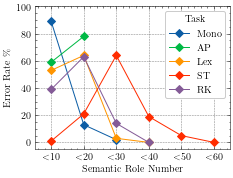

In [284]:

import matplotlib.pyplot as plt
import numpy as np
from math import ceil

pparam = dict(xlabel='Semantic Role Number', ylabel='Error Rate \%')
report = py_io.read_json(f'./analyze/num_sem_role/report.json')['bert-base-mlp']

task_ab = {
    'monotonicity': 'Mono',
    'sentiment': 'ST',
    'anaphora': 'AP',
    'lexical': 'Lex',
    'relational_vertex': 'RK'
}

with plt.style.context(['science', 'grid']):
    fig, ax = plt.subplots()
    for task in report:
        x = report[task][0]
        y = report[task][1]
        ax.plot(x, y, label=task_ab[task], marker='D')
    ax.legend(title='Task')
    ax.autoscale(tight=True)
    ax.set_xticklabels(['10', '$<$10', '$<$20', '$<$30', '$<$40', '$<$50', '$<$60'])
    ax.set_xlim([5, 65])
    ax.set_ylim([-5, 100])
    ax.set(**pparam)
    fig.savefig('analyze/num_sem_role/num_sem_role.pdf')